In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier, MLPRegressor

import copy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


-----
**Notebook**

        
Real problems  
    
    MNIST + autoencoder (convnet)
    
Trip Classification:
    
    Maybe?
    
RNN toy problems

    Linear trend + noise
    
    Different data structuring strategies
    
    Quadratic trend + noise
    
    LSTM/GRUs for same problems
    
Seq2Seq examples
    
RNN Autoencoder

    What data?
    


# Goals of this notebook

We want to introduce the basics of neural networks and deep learning. Modern deep learning is a huge field and it's impossible to cover even all the significant developments in the last 5 years here. But the basics are straightforward.

One big caveat: deep learning is a rapidly evolving field. There are new developments in neural network architectures, novel applications, better optimization techniques, theoretical results justifying why something works etc. daily. It's a great opportunity to get involved if you find research interesting and there are great online communities (pytorch, fast.ai, paperswithcode, pysyft) that you should get involved with.

**Note**: Unlike the previous notebooks, this notebook has very few/no questions. You should study the code, tweak the data, the parameters, and poke the models to understand what's going on.

## Synthetic/Artificial Datasets

We covered the basics of neural networks in the lecture. We also saw applications to two synthetic datasets. The goal in this section is to replicate those results and get a feel for using pytorch.

### Classification

In [4]:
def generate_binary_data(N_examples=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    features = []
    target = []

    for i in range(N_examples):
        #class = 0
        r = np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(0)

        #class = 1
        r = 3 + np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(1)

    features = np.array(features)
    target = np.array(target)

    return features, target    

In [5]:
features, target = generate_binary_data(seed=100)

In [6]:
def plot_binary_data(features, target):
    plt.figure(figsize=(10,10))
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

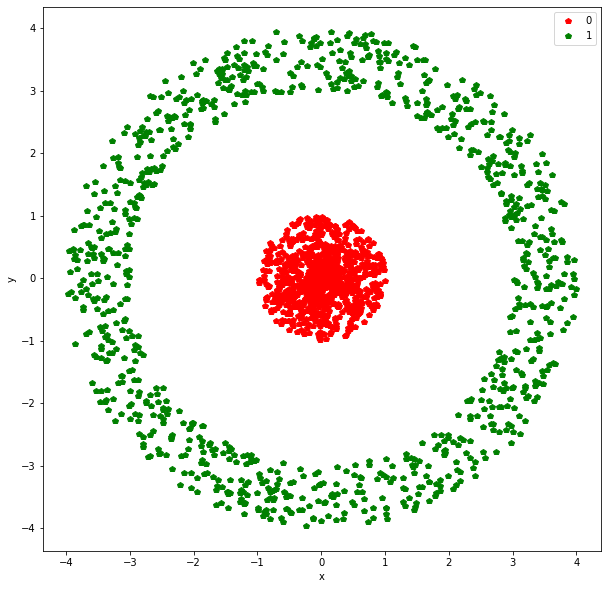

In [7]:
plot_binary_data(features, target)

We have two features here - x and y. There is a binary target variable that we need to predict. This is essentially the dataset during the logistic regression discussion. Logistic regression will not do well here given that the data is not linearly separable. Transforming the data so we have two features:

$$r^2  = x^2 + y^2$$

and

$$\theta = \arctan(\frac{y}{x})$$

would make it very easy to use logistic regression (or just a cut at $r = 2$) to separate the two classes but while it is easy for us to visualize the data and guess at the transformation, in high dimensions, we can't follow the same process.

Let's implement a feed-forward neural network that takes the two features as input and predicts the probabiliy of being in class 1 as output.

#### Architecture Definition

In [8]:
class ClassifierNet(nn.Module): #inherit from nn.Module to define your own architecture
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(ClassifierNet, self).__init__()
        
        self.N_inputs = N_inputs #2 in our case
        self.N_outputs = N_outputs #1 in our case but can be higher for multi-class classification
        
        self.N_hidden_layers = N_hidden_layers #we'll start by using one hidden layer
        self.N_hidden_nodes = N_hidden_nodes #number of nodes in each hidden layer - can extend to passing a list
        
        #Define layers below - pytorch has a lot of layers pre-defined
        
        #use nn.ModuleList or nn.DictList instead of [] or {} - more explanations below
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation #activations at inner nodes
        self.output_activation = output_activation #activation at last layer (depends on your problem)
        
    def forward(self, inp):
        '''
        every neural net in pytorch has its own forward function
        this function defines how data flows through the architecture from input to output i.e. the forward propagation part
        '''
        
        out = inp
        for layer in self.layer_list:
            out = layer(out) #calls forward function for each layer (already implemented for us)
            out = self.activation(out) #non-linear activation
            
        #pass activations through last/output layer
        out = self.output_layer(out)
        if self.output_activation is not None:
            pred = self.output_activation(out)
        else:
            pred = out
        
        return pred

There are several ways of specifying a neural net architecture in pytorch. You can work at a high level of abstraction by just listing the layers that you want to getting into the fine details by constructing your own layers (as classes) that can be used in ClassifierNet above.

How does pytorch work? When you define an architecture like the one above, pytorch constructs a graph (nodes and edges) where the nodes are operations on 

In [9]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

#### Training

**Loss function**

We first need to pick our loss function. Like we binary classification problems (including logistic regression), we'll use binary cross-entropy:

$$\text{Loss, } L = -\Sigma_{i=1}^{N} y_i \log(p_i) + (1-y_i) \log(1-p_i)$$

where $y_i \in {0,1}$ are the labels and $p_i \in [0,1]$ are the probability predictions.

In [10]:
#look at all available losses (you can always write your own)
#torch.nn.*Loss?

In [11]:
criterion = nn.BCELoss()

In [12]:
#target = 1 (label = 1)
print(criterion(torch.tensor(1e-2), torch.tensor(1.))) #pred prob = 1e-2 -> BAD
print(criterion(torch.tensor(0.3), torch.tensor(1.))) #pred prob = 0.3 -> BAd
print(criterion(torch.tensor(0.5), torch.tensor(1.))) #pred prob = 0.5 -> Bad
print(criterion(torch.tensor(1.), torch.tensor(1.))) #pred prob = 1.0 -> GREAT!

tensor(4.6052)
tensor(1.2040)
tensor(0.6931)
tensor(0.)


**Optimizer**:

So we have the data, the neural net architecture, a loss function to measure how well the model does on our task. We also need a way to do gradient descent.

Recall, we use gradient descent to minimize the loss by computing the first derivative (gradients) and taking a step in the direction opposite (since we are minimizing) to the gradient:

$$w_{t} \rightarrow w_{t} - \eta \frac{\partial L}{\partial w_{t-1}}$$

where $w_t$ = weight at time-step t, $L$ = loss, $\eta$ = learning rate.

For our neural network, we first need to calculate the gradients. Thankfully, this is done automatically by pytorch using a procedure called **backpropagation**. If you are interested in more calculations details, please check "automatic differentiation" and an analytical calculation for a feed-forward network (https://treeinrandomforest.github.io/deep-learning/2018/10/30/backpropagation.html).

The gradients are calculated by calling a function **backward** on the network, as we'll see below.

Once the gradients are calculated, we need to update the weights. In practice, there are many heuristics/variants of the update step above that lead to better optimization behavior. A great resource to dive into details is https://ruder.io/optimizing-gradient-descent/. We won't get into the details here.

We'll choose what's called the **Adam** optimizer.

In [13]:
#optim.*?

In [14]:
optimizer = optim.Adam(net.parameters(), lr=1e-2)

We picked a constant learning rate here (which is adjusted internally by Adam) and also passed all the tunable weights in the network by using: net.parameters()

In [15]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.4402, -0.5505],
         [ 0.5065, -0.3424]], requires_grad=True), Parameter containing:
 tensor([0.5974, 0.6466], requires_grad=True), Parameter containing:
 tensor([[0.2329, 0.2916]], requires_grad=True), Parameter containing:
 tensor([0.4763], requires_grad=True)]

There are 9 free parameters:

* A 2x2 matrix (4 parameters) mapping the input layer to the 1 hidden layer.

* A 2x1 matrix (2 parameters) mapping the hidden layer to the output layer with one node.

* 2 biases for the 2 nodes in the hidden layer.

* 1 bias for the output node in the output layer.


This is a good place to explain why we need to use nn.ModuleList. If we had just used a vanilla python list, net.parameters() would only show weights that are explicitly defined in our net architecture. The weights and biases associated with the layers would NOT show up in net.parameters(). This process of a module higher up in the hierarchy (ClassifierNet) subsuming the weights and biases of modules lower in the hierarchy (layers) is called **registering**. ModuleList ensures that all the weights/biases are registered as weights and biases of ClassifierNet.

Let's combine all these elements and train our first neural net.

In [16]:
#convert features and target to torch tensors
features = torch.from_numpy(features)
target = torch.from_numpy(target)

In [17]:
#if have gpu, throw the model, features and labels on it
net = net.to(device)
features = features.to(device).float()
target = target.to(device).float()

We need to do the following steps now:

* Compute the gradients for our dataset.

* Do gradient descent and update the weights.

* Repeat till ??

The problem is there's no way of knowing when we have converged or are close to the minimum of the loss function. In practice, this means we keep repeating the process above and monitor the loss as well as performance on a hold-out set. When we start over-fitting on the training set, we stop. There are various modifications to this procedure but this is the essence of what we are doing.

Each pass through the whole dataset is called an **epoch**.

In [18]:
N_epochs = 2
for epoch in range(N_epochs):
    out = net(features) #make predictions on the inputs
    loss = criterion(out, target) #compute loss on our predictions
    
    optimizer.zero_grad() #set all gradients to 0
    loss.backward() #backprop to compute gradients
    optimizer.step() #update the weights
    
    if epoch % 10 == 0:
        print(f'Loss = {loss:.4f}')

Loss = 0.7795


/home/sanjay/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Let's combined all these elements into a function

In [19]:
def train_model(features, target, model, lr, N_epochs, criterion=nn.BCELoss(), shuffle=False):
    #criterion = nn.BCELoss() #binary cross-entropy loss as before
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam optimizer

    #if have gpu, throw the model, features and labels on it
    model = model.to(device)
    features = features.to(device)
    target = target.to(device)

    for epoch in range(N_epochs):
        if shuffle: #should have no effect on gradients in this case
            indices = torch.randperm(len(features))

            features_shuffled = features[indices]
            target_shuffled = target[indices]
        else:
            features_shuffled = features
            target_shuffled = target

        out = model(features_shuffled)
        #out = out.reshape(out.size(0))
        loss = criterion(out, target_shuffled)

        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = model(features_shuffled).reshape(len(target))
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0

    #print(f'Accuracy = {accuracy}')
        
    model = model.to('cpu')
    features = features.to('cpu')
    target = target.to('cpu')

    return model

**Exercise**: Train the model and vary the number of hidden nodes and see what happens to the loss. Can you explain this behavior? 

In [20]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 1
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.74462890625
epoch = 1000 loss = 0.6511412858963013
epoch = 2000 loss = 0.600830614566803
epoch = 3000 loss = 0.5709505677223206
epoch = 4000 loss = 0.5543113350868225
epoch = 5000 loss = 0.5444762110710144
epoch = 6000 loss = 0.5382871627807617
epoch = 7000 loss = 0.5341762900352478
epoch = 8000 loss = 0.531323254108429
epoch = 9000 loss = 0.5292809009552002


In [21]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10)

epoch = 0 loss = 0.7241912484169006
epoch = 1000 loss = 0.6301650404930115
epoch = 2000 loss = 0.4533305764198303
epoch = 3000 loss = 0.3579755425453186
epoch = 4000 loss = 0.30576568841934204
epoch = 5000 loss = 0.2759447693824768
epoch = 6000 loss = 0.25859856605529785
epoch = 7000 loss = 0.24831832945346832
epoch = 8000 loss = 0.24212956428527832
epoch = 9000 loss = 0.2383338063955307


In [22]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 3
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10)

epoch = 0 loss = 0.7113596200942993
epoch = 1000 loss = 0.5776105523109436
epoch = 2000 loss = 0.419190376996994
epoch = 3000 loss = 0.2826436161994934
epoch = 4000 loss = 0.16111376881599426
epoch = 5000 loss = 0.10423625260591507
epoch = 6000 loss = 0.07115206867456436
epoch = 7000 loss = 0.04985847696661949
epoch = 8000 loss = 0.035422779619693756
epoch = 9000 loss = 0.025379370898008347


There seems to be some "magic" behavior when we increase the number of nodes in the first (and only) hidden layer from 2 to 3. Loss suddenly goes down dramatically. At this stage, we should explore why that's happening.

For every node in the hidden layer, we have a mapping from the input to that node:

$$\sigma(w_1 x + w_2 y + b)$$

where $w_1, w_2, b$ are specific to that hidden node. We can plot the decision line in this case:

$$w_1 x + w_2 y + b = 0$$

Unlike logistic regression, this is not actually a decision line. Points on one side are not classified as 0 and points on the other side as 1 (if the threshold = 0.5). Instead this line should be thought of as one defining a new coordinate-system. Instead of x and y coordinates, every hidden node induces a straight line and a new coordinate, say $\alpha_i$. So if we have 3 hidden nodes, we are mapping the 2-dimensional input space into a 3-dimensional space where the coordinates $\alpha_1, \alpha_2, \alpha_3$ for each point depend on which side of the 3 lines induced as mentioned above, it lies.

In [23]:
params = list(net.parameters())

In [24]:
print(params[0]) #3x2 matrix
print(params[1]) #3 biases

Parameter containing:
tensor([[-4.4170, -0.4989],
        [ 2.1199, -2.7683],
        [-1.8429, -4.0280]], requires_grad=True)
Parameter containing:
tensor([-5.9301, -4.9424,  6.2077], requires_grad=True)


In [25]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

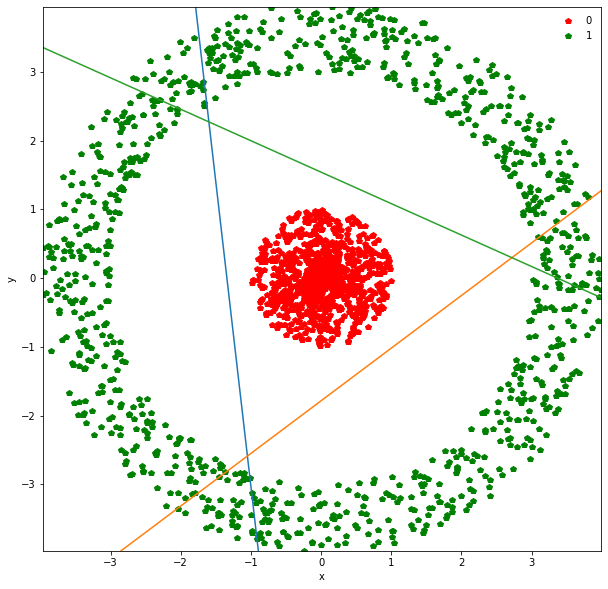

In [26]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot()

#plot raw data
ax.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
ax.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

plt.xlabel('x')
plt.ylabel('y')

#get weights and biases
weights = params[0].detach().numpy()
biases = params[1].detach().numpy()

#plot straight lines
x_min, x_max = features[:,0].min(), features[:,0].max()
y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
for i in range(weights.shape[0]): #loop over each hidden node in the one hidden layer
    coef = weights[i]
    intercept = biases[i]
    
    y_min = (-intercept - coef[0]*x_min)/coef[1]
    y_max = (-intercept - coef[0]*x_max)/coef[1]
    
    ax.plot([x_min, x_max], [y_min, y_max])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_lim_min, y_lim_max)
ax.legend(framealpha=0)

This is the plot we showed in the lecture. For every hidden node in the hidden layer, we have a straight line. The colors of the three lines above are orange, green and blue and that's what we'll call our new coordinates.

Suppose you pick a point in the red region:

* It lies to the *right* of the orange line

* It lies to the *bottom* of the green line

* It lies to the *top* of the blue line.

On the other hand, we have **6** green regions. If you start walking clockwise from the top green section, every time you cross a straight line, you walk into a new region. Each time you walk into a new region, you flip the coordinate of one of the 3 lines. Either you go from *right* to *left* of the orange line, *bottom* to *top* of the green line or *top* to *bottom* of the blue line.

So instead of describing each point by two coordinates (x, y), we can describe it by (orange status, green status, blue status). We happen to have 7 such regions here - with 1 being purely occupied by the red points and the other 7 by green points.

This might be become cleared from a 3-dimensional plot.

In [27]:
from mpl_toolkits.mplot3d import Axes3D

In [28]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()
print(features_layer1_3d[0:10])

[[3.1061368e-03 1.3222205e-03 9.8567164e-01]
 [2.2597035e-06 9.9906868e-01 9.9999928e-01]
 [2.6075470e-03 7.0742546e-03 9.9795085e-01]
 [7.9598631e-06 9.9952745e-01 9.9999988e-01]
 [4.6733310e-03 6.5059615e-03 9.9874878e-01]
 [5.2058176e-06 1.7231635e-06 2.0963977e-05]
 [1.3259724e-03 6.9633070e-03 9.9581641e-01]
 [2.4966995e-09 9.5324832e-01 8.8738608e-01]
 [3.4350020e-04 2.2067651e-03 9.3207783e-01]
 [5.1065246e-03 6.1431976e-08 3.6004488e-04]]


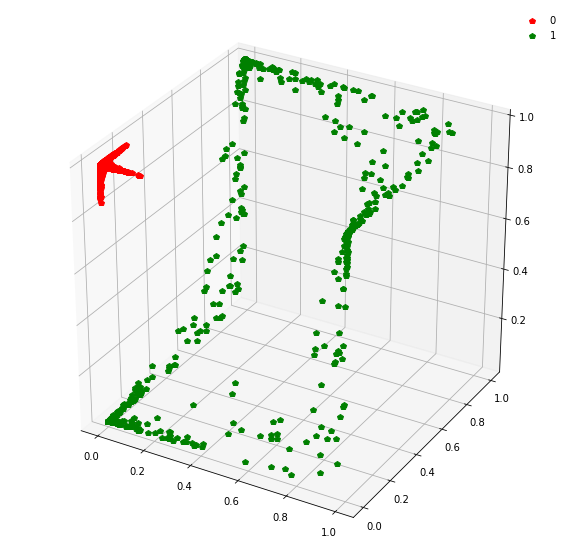

In [29]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

ax.plot(features_layer1_3d[target==0][:,0], features_layer1_3d[target==0][:,1], features_layer1_3d[target==0][:,2], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,0], features_layer1_3d[target==1][:,1], features_layer1_3d[target==1][:,2], 'p', color ='g', label='1')

ax.legend(framealpha=0)

At this stage, a simple linear classifier can draw a linear decision boundary (a plane) to separate the red points from the green points. Also, these points lie in the unit cube (cube with sides of length=1) since we are using sigmoid activations. Whenever the activations get saturated (close to 0 or 1), then we see points on the edges and corners of the cube.

**Question**: Switch the activation from sigmoid to relu (nn.ReLU()). Does the loss still essentially become zero on the train set? If not, try increasing N_hidden_nodes. At what point does the loss actually become close to 0?

In [30]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 5
activation = nn.ReLU()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(features)
target = torch.tensor(target)

net = train_model(features, target, net, 1e-3, 10)

epoch = 0 loss = 0.634027898311615
epoch = 1000 loss = 0.16544611752033234
epoch = 2000 loss = 0.07275258004665375
epoch = 3000 loss = 0.039382193237543106
epoch = 4000 loss = 0.023319801315665245
epoch = 5000 loss = 0.014427577145397663
epoch = 6000 loss = 0.009151075966656208
epoch = 7000 loss = 0.005887577310204506
epoch = 8000 loss = 0.0038221217691898346
epoch = 9000 loss = 0.0024949098005890846


**Question**: Remake the 3d plot but by trying 3 coordinates out of the N_hidden_nodes coordinates you found above?

In [31]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

[[0.         0.         0.         0.         0.        ]
 [4.6866293  0.         2.926527   0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [5.1983294  0.         2.454482   0.04158068 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         8.22757    0.         0.         3.706375  ]
 [0.         0.         0.         0.         0.        ]
 [1.746964   1.2168484  5.432694   0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         5.7684407  0.         0.         6.2181473 ]]


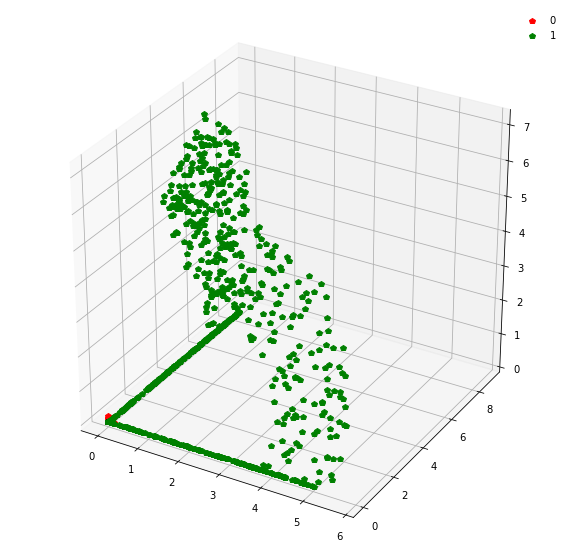

In [32]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()

print(features_layer1_3d[0:10])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 2

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

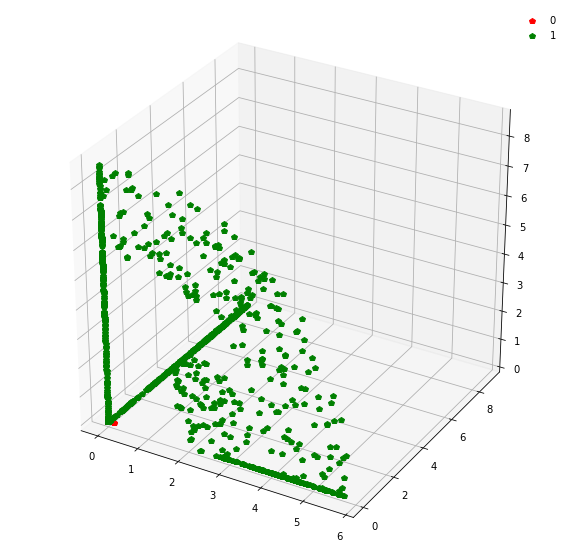

In [33]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

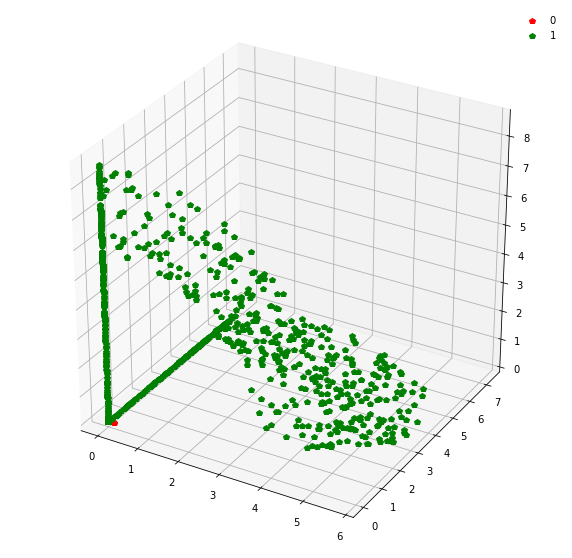

In [34]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

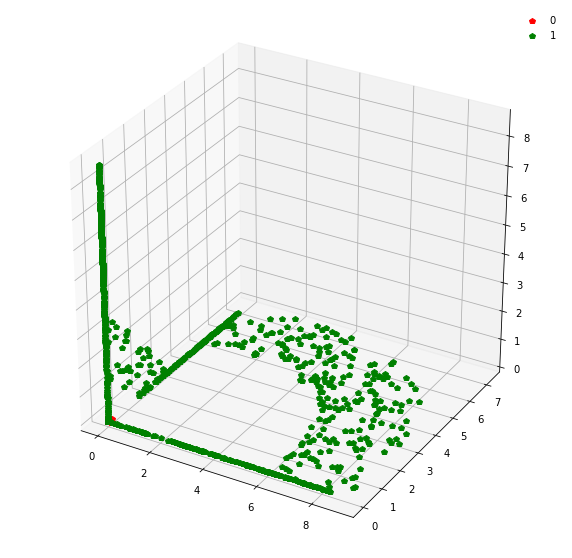

In [35]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 1
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

Draw all the plots

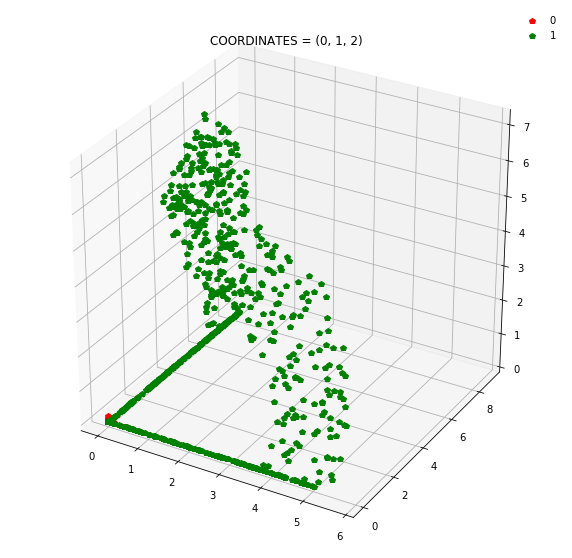

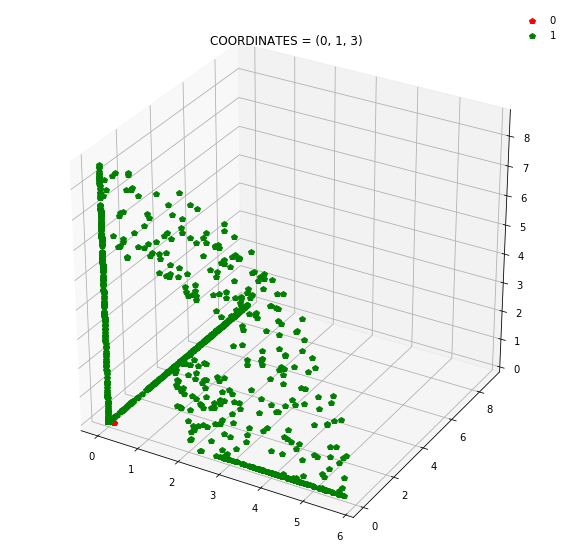

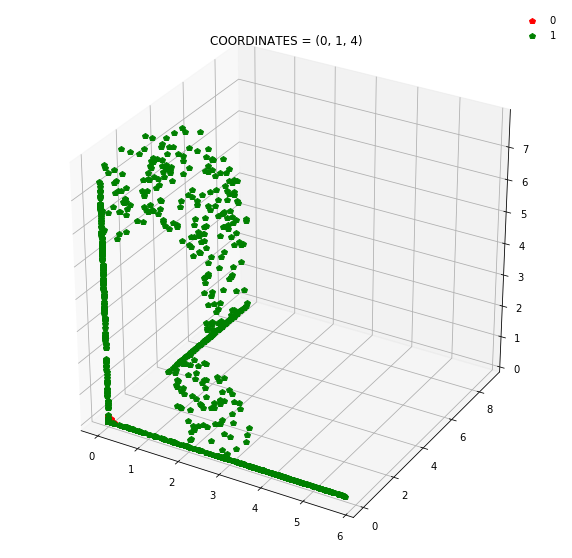

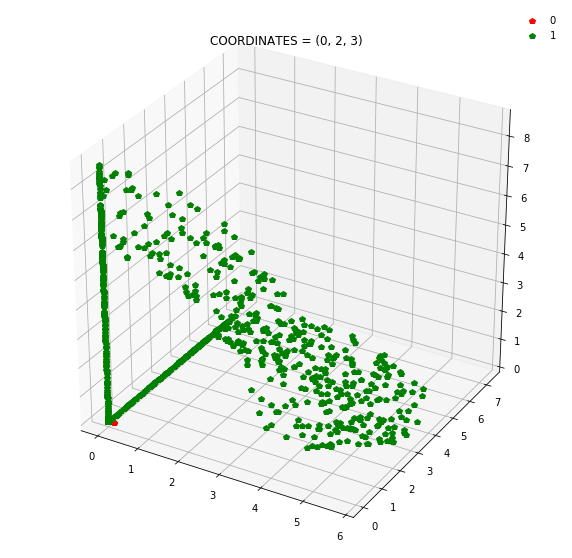

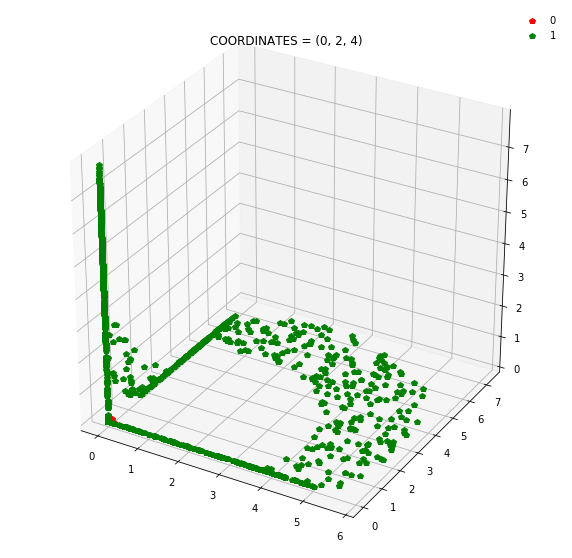

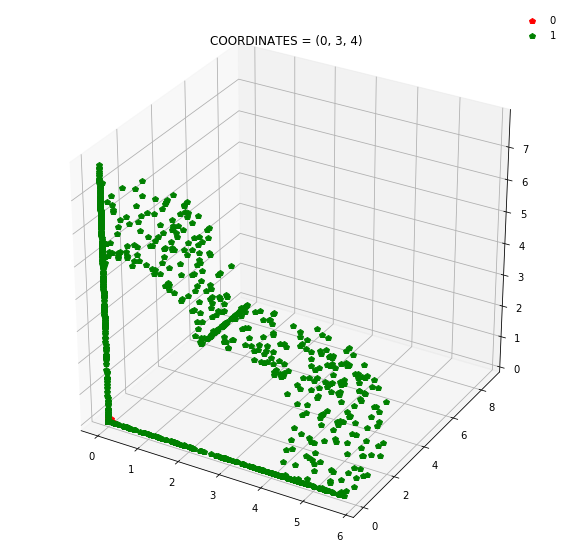

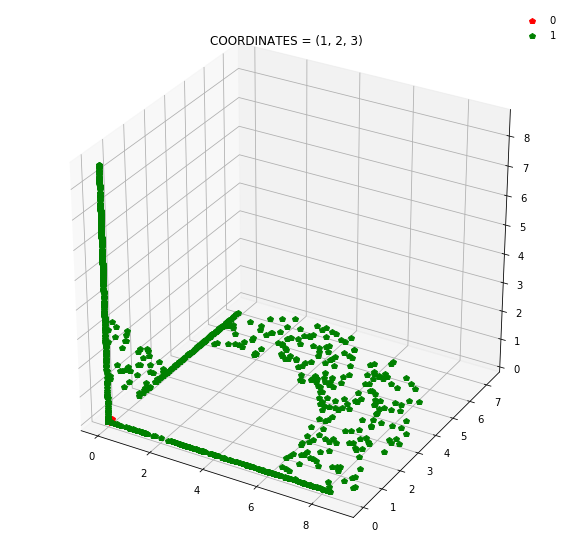

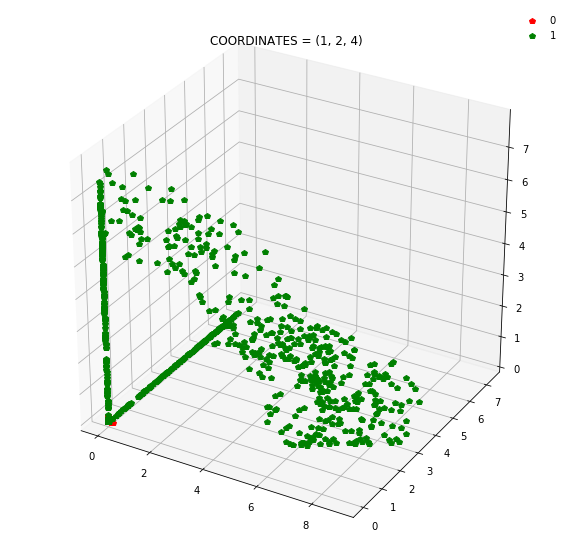

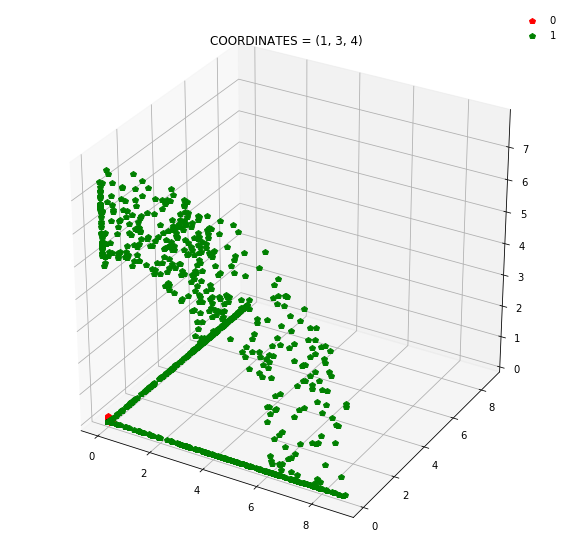

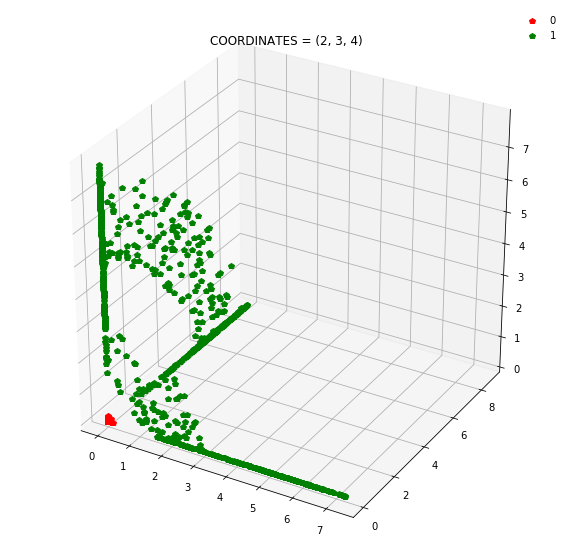

In [36]:
import itertools

for comb in itertools.combinations(np.arange(N_hidden_nodes), 3):
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(projection='3d')

    COORD1 = comb[0]
    COORD2 = comb[1]
    COORD3 = comb[2]

    ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
    ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

    ax.legend(framealpha=0)
    
    plt.title(f'COORDINATES = {comb}')

**Note**: Generally it is a good idea to use a linear layer for the output layer and use BCEWithLogitsLoss to avoid numerical instabilities. We will do this later for multi-class classification.

### Regression

In [37]:
def generate_regression_data(L=10, stepsize=0.1):
    x = np.arange(-L, L, stepsize)
    y = np.sin(3*x) * np.exp(-x / 8.)

    return x, y

def plot_regression_data(x, y):
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    
    plt.xlabel('x')
    plt.ylabel('y')

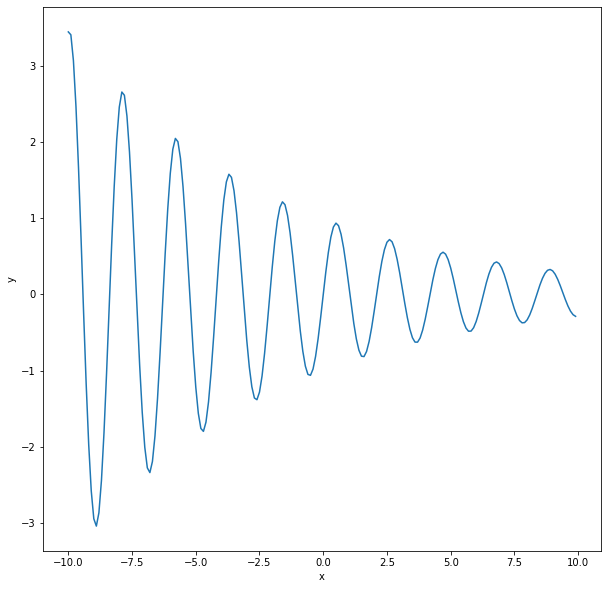

In [38]:
x, y = generate_regression_data()
plot_regression_data(x, y)

This is a pretty different problem in some ways. We now have one input - x and one output - y. But looked at another way, we simply change the number of inputs in our neural network to 1 and we change the output activation to be a linear function. Why linear? Because in principle, the output (y) can be unbounded i.e. any real value.

We also need to change the loss function. While binary cross-entropy is appropriate for a classification problem, we need something else for a regression problem. We'll use mean-squared error:

$$\frac{1}{2}(y_{\text{target}} - y_{\text{pred}})^2$$

In [39]:
N_inputs = 1
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.Sigmoid()
output_activation = None #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(x).float().reshape(len(x), 1)
target = torch.tensor(y).float().reshape(len(y), 1)

In [40]:
net = train_model(features, target, net, 1e-2, 20, criterion=nn.MSELoss())

epoch = 0 loss = 1.31950044631958


In [41]:
pred = net(features).cpu().detach().numpy().reshape(len(features))

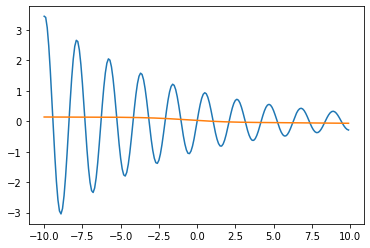

In [42]:
plt.plot(x, y)
plt.plot(x, pred)

As before, we need to understand what the model is doing. As before, let's consider the mapping from the input node to one node of the hidden layer. In this case, we have the mapping:

$$\sigma(w_i x + b_i)$$

where $w_i, b_i$ are the weight and bias associated with each node of the hidden layer. This defines a "decision" boundary where:

$$w_i x + b_i = 0$$

This is just a value $\delta_{i} \equiv -\frac{b_i}{w_i}$. 

For each hidden node $i$, we can calculate one such threshold, $\delta_i$.

As we walk along the x-axis from the left to right, we will cross each threshold one by one. On crossing each threshold, one hidden node switches i.e. goes from $0 \rightarrow 1$ or $1 \rightarrow 0$. What effect does this have on the output or prediction?

Since the last layer is linear, its output is:

$y = v_1 h_1 + v_2 h_2 + \ldots + v_n h_n + c$

where $v_i$ are the weights from the hidden layer to the output node, $c$ is the bias on the output node, and $h_i$ are the activations on the hidden nodes. These activations can smoothly vary between 0 and 1 according to the sigmoid function.

So, when we cross a threshold, one of the $h_j$ values eithers turns off or turns on. This has the effect of adding or subtracting constant $v_k$ values from the output if the kth hidden node, $h_k$ is switching on/off.

This means that as we add more hidden nodes, we can divide the domain (the x values) into more fine-grained intervals that can be assigned a single value by the neural network. In practice, there is a smooth interpolation.

**Question**: Suppose instead of the sigmoid activations, we used a binary threshold:

$$\sigma(x) = \begin{cases}
1 & x > 0 \\
0 & x \leq 0
\end{cases}$$

then we would get a piece-wise constant prediction from our trained network. Plot that piecewise function as a function of $x$.

In [43]:
activations = net.activation(net.layer_list[0](features))
print(activations[0:10])

tensor([[9.9152e-01, 9.8464e-01, 2.4250e-02, 3.3710e-01, 3.6905e-02, 2.3627e-03,
         8.9185e-02, 1.3080e-01, 1.8801e-04, 6.0387e-02],
        [9.9113e-01, 9.8404e-01, 2.5110e-02, 3.3645e-01, 3.7858e-02, 2.5229e-03,
         9.1628e-02, 1.3320e-01, 2.0368e-04, 6.1707e-02],
        [9.9073e-01, 9.8341e-01, 2.5999e-02, 3.3581e-01, 3.8835e-02, 2.6939e-03,
         9.4130e-02, 1.3564e-01, 2.2065e-04, 6.3053e-02],
        [9.9031e-01, 9.8276e-01, 2.6919e-02, 3.3516e-01, 3.9836e-02, 2.8764e-03,
         9.6694e-02, 1.3811e-01, 2.3904e-04, 6.4427e-02],
        [9.8987e-01, 9.8209e-01, 2.7870e-02, 3.3452e-01, 4.0861e-02, 3.0713e-03,
         9.9320e-02, 1.4062e-01, 2.5896e-04, 6.5828e-02],
        [9.8941e-01, 9.8139e-01, 2.8854e-02, 3.3388e-01, 4.1912e-02, 3.2794e-03,
         1.0201e-01, 1.4317e-01, 2.8054e-04, 6.7258e-02],
        [9.8893e-01, 9.8066e-01, 2.9872e-02, 3.3323e-01, 4.2988e-02, 3.5015e-03,
         1.0476e-01, 1.4576e-01, 3.0391e-04, 6.8716e-02],
        [9.8843e-01, 9.7991

In [44]:
binary_activations = nn.Threshold(0.5, 0)(activations)/activations
print(binary_activations[0:10])

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SliceBackward>)


In [45]:
binary_pred = net.output_layer(binary_activations)

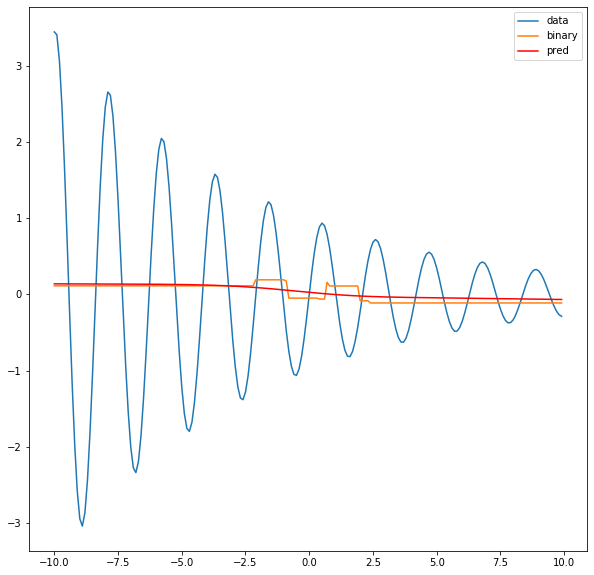

In [46]:
plt.figure(figsize=(10,10))
plt.plot(x,y, label='data')
plt.plot(x, binary_pred.cpu().detach().numpy(), label='binary')
plt.plot(x, pred, color='r', label='pred')
plt.legend()

**Question**: Why does the left part of the function fit so well but the right side is always compromised? Hint: think of the loss function.

The most likely reason is that the loss function is sensitive to the scale of the $y$ values. A 10% deviation between the y-value and the prediction near x = -10 has a larger absolute value than a 10% deviation near say, x = 5.

**Question**: Can you think of ways to test this hypothesis?

There are a couple of things you could do. One is to flip the function from left to right and re-train the model. In this case, the right side should start fitting better.

Another option is to change the loss function to percentage error i.e.:

$$\frac{1}{2} \big(\frac{y_{\text{target}} - y_{\text{pred}}}{y_{\text{target}}}\big)^2$$

but this is probably much harder to optimize.

In [47]:
y = copy.copy(y[::-1])

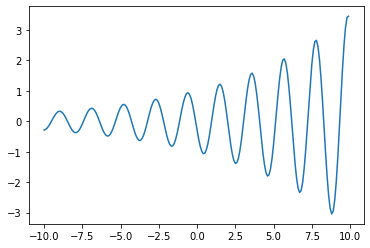

In [48]:
plt.plot(x, y)

In [49]:
N_inputs = 1
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.Sigmoid()
output_activation = None #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(x).float().reshape(len(x), 1)
target = torch.tensor(y).float().reshape(len(y), 1)

In [50]:
net = train_model(features, target, net, 1e-2, 2, criterion=nn.MSELoss())

epoch = 0 loss = 1.2645610570907593


In [51]:
pred = net(features).cpu().detach().numpy().reshape(len(features))

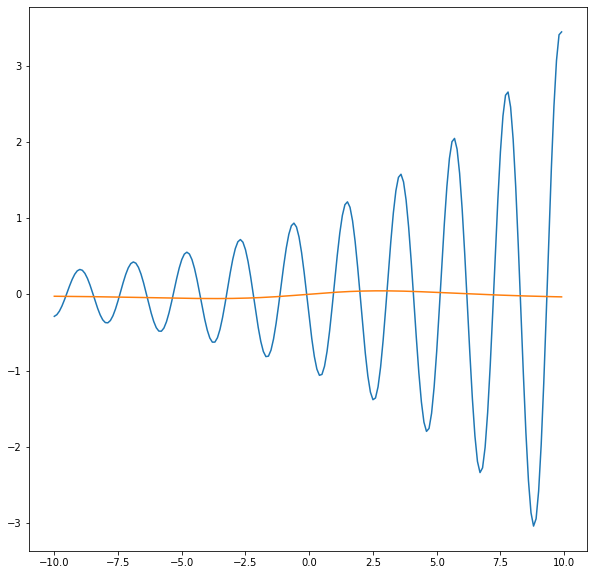

In [52]:
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.plot(x, pred)

As expected, now the right side of the function fits well.

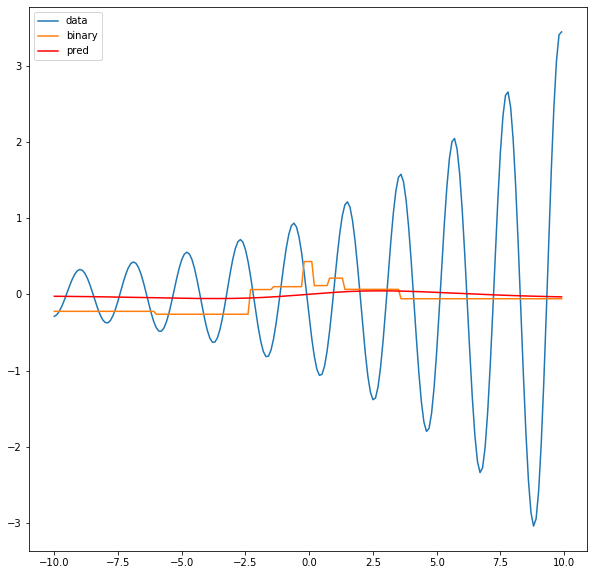

In [53]:
activations = net.activation(net.layer_list[0](features))
binary_activations = nn.Threshold(0.5, 0)(activations)/activations
binary_pred = net.output_layer(binary_activations)

plt.figure(figsize=(10,10))
plt.plot(x,y, label='data')
plt.plot(x, binary_pred.cpu().detach().numpy(), label='binary')
plt.plot(x, pred, color='r', label='pred')
plt.legend()

### Image Classification

One of the most successful applications of deep learning has been to computer vision. A central task of computer vision is **image classification**. This is the task of assigning exactly one of multiple labels to an image. 

pytorch provides a package called **torchvision** which includes datasets, some modern neural network architectures as well as helper functions for images.

In [54]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [55]:
DOWNLOAD_PATH = "../data/MNIST"

In [56]:
mnist_train = MNIST(DOWNLOAD_PATH, 
                    train=True, 
                    download=True,
                    transform = transforms.Compose([transforms.ToTensor()]))

mnist_test = MNIST(DOWNLOAD_PATH, 
                   train=False, 
                   download=True,
                   transform = transforms.Compose([transforms.ToTensor()]))

MNIST is one of the classic image datasets and consists of 28 x 28 pixel images of handwritten digits. We downloaded both the train and test sets. Transforms defined under target_transform will be applied to each example. In this example, we want tensors and not images which is what the transforms do.

The train set consists of 60000 images.

In [57]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [58]:
mnist_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

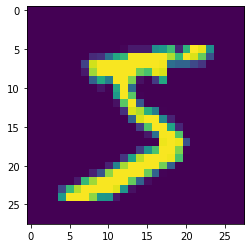

In [59]:
plt.imshow(mnist_train.data[0])

There are 10 unique labels - 0 through 9

In [60]:
mnist_train.targets[0:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

The labels are roughly equally/uniformly distributed

In [61]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

The test set consists of 10000 images.

In [62]:
mnist_test.data.shape

torch.Size([10000, 28, 28])

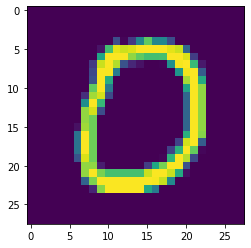

In [63]:
plt.imshow(mnist_test.data[10])

Same labels

In [64]:
mnist_test.targets[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

Pretty equally distributed.

In [65]:
np.unique(mnist_test.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

**Image Classifier**:

We first have to pick an architecture. The first one we'll pick is a feed-forward neural network like the one we used in the exercises above. This time I am going to use a higher abstraction to define the network.

In [66]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=2)

In [67]:
Flatten()(mnist_train.data[0:10]).shape

torch.Size([10, 784])

Architecture definition using nn.Sequential. You can just list the layers in a sequence. We carry out the following steps:

* Flatten each image into a 784 dimensional vector

* Map the image to a 100-dimensional vector using a linear layer

* Apply a relu non-linearity

* Map the 100-dimensional vector into a 10-dimensional output layer since we have 10 possible targets.

* Apply a softmax activation to convert the 10 numbers into a probability distribution that assigns the probability the image belonging to each class (0 through 9)

A softmax activation takes N numbers $a_1, \ldots, a_{10}$ and converts them to a probability distribution. The first step is to ensure the numbers are positive (since probabilities cannot be negative). This is done by exponentiation.

$$a_i \rightarrow e^{a_i}$$

The next step is to normalize the numbers i.e. ensure they add up to 1. This is very straightforward. We just divide each score by the sum of scores:

$$p_i = \frac{e^{a_i}}{e^{a_1} + e^{a_2} + \ldots + e^{a_N}}$$

This is the softmax function. If you have done statistical physics (physics of systems with very large number of interacting constituents), you probably have seen the Boltzmann distribution:

$$p_i = \frac{e^{-\beta E_i}}{e^{-\beta E_1} + e^{-\beta E_2} + \ldots + e^{-\beta E_N}}$$

which gives the probability that a system with N energy levels is in the state with energy $i$ when it is in equilibrium with a thermal bath at temperature $T = \frac{1}{k_B\beta}$. This is the only probability distribution that is invariant to constant shifts in energy: $E_i \rightarrow E_i + \Delta$.

In [68]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                             nn.Softmax(dim=1) #convert 10-dim activation to probability distribution
                            )

Let's ensure the data flows through our neural network and check the dimensions.

In [69]:
image_ff_net(mnist_train.data[0:12].float()).shape

torch.Size([12, 10])

We get a 10-dimensional output as expected.

**Question**: Check that the outputs for each image are actually a probability distribution (the numbers add up to 1).

In [70]:
image_ff_net(mnist_train.data[0:10].float()).sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SumBackward2>)

**Question**: We have an architecture for our neural network but we now need to decide what loss to pick. Unlike the classification problem earlier which had two classes, we have 10 classes here. Take a look at the pytorch documentation - what loss do you think we should pick to model this problem?

We used cross-entropy loss on days 2 and 3. We need the same loss here. Pytorch provides NLLLoss (negative log likelihood) as well as CrossEntropyLoss.

**Question**: Look at the documentation for both of these loss functions. Which one should we pick? Do we need to make any modifications to our architecture?

TODO: add details of log-sum-exp

In [71]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

Now we'll get raw unnormalized scores that were used to compute the probabilities. We should use nn.CrossEntropyLoss in this case.

In [72]:
image_ff_net(mnist_train.data[0:12].float())

tensor([[ 21.6311,  -6.7257,  -2.0976,  21.1820,  -1.3306,  19.2640,  10.0901,
           7.4723, -22.4010,  30.4166],
        [ 11.1431, -16.5841, -20.6891, -14.2887,  -1.4988,   8.8940,  -2.7491,
          10.6489, -13.3949,  26.5651],
        [-16.6421,  -8.1106,  -8.7534,  -7.3515,   0.4575,  10.5783,   1.7735,
           3.8328,  19.3681,   8.5857],
        [ 15.8700,   4.8049, -21.2973,  14.1075,  -2.7444,  -0.2199,  36.1654,
           7.7235,   4.8880,  -0.7773],
        [  8.7051,  -7.1571, -22.4876,  17.2701,  -3.9660,  -0.9789,  -4.7434,
           7.5535,  10.9237,   5.6652],
        [-12.4813, -25.8988, -32.9353,  22.0624,   2.4292,  18.0297,  20.9472,
          -6.5607,  -4.6623,  18.8433],
        [  2.5432,  -6.9602, -19.6801,   1.5437,  34.3983,  -3.5472,  12.5476,
           9.7113,   9.7900,  -4.8099],
        [  7.2886,  -3.4558,  -4.7918,  -8.2692,  10.9251,  -3.1951,   8.8132,
          -1.4218,   9.5409,  12.2980],
        [ -6.5615,  -2.9759, -20.4669,   2.8182,

In [73]:
loss = nn.CrossEntropyLoss()

**Training**: We have an architecture, the data, an appropriate loss. Now we need to loop over the images, use the loss to compare the predictions to the targets, compute the gradients and update the weights.

In our previous examples, we had N_epoch passes over our dataset and each time, we computed predictions for the full dataset. This is impractical as datasets gets larger. Instead, we need to split the data into **batches** of a fixed size, compute the loss, the gradients and update the weights for each batch.


pytorch provides a DataLoader class that makes it easy to generate batches from your dataset.

**Optional**:

Let's analyze how using batches can be different from using the full dataset. Suppose our data has 10,000 rows but we use batches of size 100 (usually we pick powers of 2 for the GPU but this is just an example). Statistically, our goal is always to compute the gradient:

$$\frac{\partial L}{\partial w_i}$$

for all the weights $w_i$. By weights here, I mean both the weights and biases and any other free or tunable parameters in our model.

In practice, the loss is a sum over all the examples in our dataset:

$$L = \frac{1}{N}\Sigma_{i}^N l(p_i, t_i)$$

where $p_i$ = prediction for ith example, $t_i$ = target/label for ith example. So the derivative is:

$$\frac{\partial L}{\partial w_i} = \frac{1}{N}\Sigma_i^N \frac{\partial l(p_i, t_i)}{\partial w_i} $$

In other words, our goal is to calculate this quantity but $N$ is too large. So we pick a randomly chosen subset of size 100 and only average the gradients over those examples. As an analogy, if our task was to measure the average height of all the people in the world which is impractical, we would pick randomly chosen subsets, say of 10,000 people and measure their average heights. 

Of course, as we make the subset smaller, the estimate we get will be noisier i.e. it has a greater chance of higher deviation from the actual value (height or gradient). Is this good or bad? It depends. In our case, we are optimizing a function (the loss) that has multiple local minima and saddle points. It is easy to get stuck in regions of the loss space/surface. Having noisy gradients can help with escaping those local minima just because we'll not always be moving in the direction of the true gradient but a noisy estimate.

Some commonly used terminology in case you read papers/articles:

* (Full) Gradient Descent - compute the gradients over the full dataset. Memory-intensive for larger datasets.

* Mini-batch Gradient Descent - use randomly chosen samples of fixed size as your data. Noisier gradients, more frequent updates to your model, memory efficient.

* Stochastic Gradient Descent - Mini-batch gradient descent with batch size = 1. Very noisy estimate, "online" updates to your model, can be hard to converge.

There are some fascinating papers on more theoretical investigations into the loss surface and the behavior of gradient descent. Here are some examples:

* https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf

* https://arxiv.org/abs/1811.03804

* https://arxiv.org/pdf/1904.06963.pdf


**End of optional section**


In [74]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )

In [75]:
train_examples = enumerate(train_dataloader)

In [76]:
idx, (data_example, target_example) = next(train_examples)

In [77]:
print(idx)
print(data_example.shape)
print(target_example.shape)

0
torch.Size([64, 1, 28, 28])
torch.Size([64])


So we have batch 0 with 64 tensors of shape (1, 28, 28) and 64 targets. Let's ensure our network can forward propagate on this batch.

In [78]:
#image_ff_net(data_example)

**Question**: Debug this error

The first shape 1792 x 28 gives us a clue. We want the two 28 sized dimensions to be flattened. But it seems like the wrong dimensions are being flattened here.

1792 = 64 * 28

We need to rewrite our flatten layer.

In [79]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)

In [80]:
Flatten()(data_example).shape

torch.Size([64, 784])

In [81]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

In [82]:
image_ff_net(data_example).shape

torch.Size([64, 10])

Let's combine all the elements together now and write our training loop.

In [83]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)
    
#ARCHITECTURE
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

#LOSS CRITERION and OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_ff_net.parameters(), lr=1e-2)


#DATALOADERS
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )

In [84]:
image_ff_net.train() #don't worry about this (for this notebook)
image_ff_net.to(device)

N_EPOCHS = 2
for epoch in range(N_EPOCHS):
    loss_list = []
    for idx, (data_example, data_target) in enumerate(train_dataloader):
        data_example = data_example.to(device)
        data_target = data_target.to(device)
        
        pred = image_ff_net(data_example)

        loss = criterion(pred, data_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        
    if epoch % 5 == 0:        
        print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')

Epoch = 0 Loss = 0.22790632786543003


**Question**: Use your trained network to compute the accuracy on both the train and test sets.

In [85]:
image_ff_net = image_ff_net.eval() #don't worry about this (for this notebook)

We'll use argmax to extract the label with the highest probability (or the least negative raw score).

In [86]:
image_ff_net(data_example).argmax(dim=1)

tensor([6, 9, 4, 2, 1, 8, 6, 6, 2, 6, 8, 7, 8, 4, 6, 0, 6, 1, 3, 3, 2, 1, 9, 3,
        1, 2, 9, 0, 0, 0, 3, 6], device='cuda:0')

In [87]:
train_pred, train_targets = torch.tensor([]), torch.tensor([])
with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
    for idx, (data_example, data_target) in enumerate(train_dataloader):
        data_example = data_example.to(device)
        
        #make predictions
        label_pred = image_ff_net(data_example).argmax(dim=1).float()
        
        #concat and store both predictions and targets
        label_pred = label_pred.to('cpu')
        train_pred = torch.cat((train_pred, label_pred))
        train_targets = torch.cat((train_targets, data_target.float()))

In [88]:
train_pred[0:10]

tensor([2., 8., 6., 0., 0., 7., 1., 6., 7., 5.])

In [89]:
train_targets[0:10]

tensor([2., 8., 6., 0., 0., 7., 1., 6., 7., 5.])

In [90]:
torch.sum(train_pred == train_targets).item() / train_pred.shape[0]

0.96725

In [91]:
train_pred.shape[0]

60000

In [92]:
assert(train_pred.shape == train_targets.shape)
train_accuracy = torch.sum(train_pred == train_targets).item() / train_pred.shape[0]
print(f'Train Accuracy = {train_accuracy:.4f}')

Train Accuracy = 0.9673


Here, I want to make an elementary remark about significant figures. While interpreting numbers like accuracy, it is important to realize how big your dataset and what impact flipping one example from a wrong prediction to the right prediction would have.

In our case, the train set has 60,000 examples. Suppose we were to flip one of the incorrectly predicted examples to a correct one (by changing the model, retraining etc etc.). This should change our accuracy, all other examples being the same, by 

$$\frac{1}{60,000} = 1.66 * 10^{-5}$$

Any digits in the accuracy beyond the fifth place have no meaning! For our test set, we have 10,000 examples so we should only care at most about the 4th decimal place (10,000 being a "nice" number i.e. a power of 10 will ensure we never have more any way).

In [93]:
test_pred, test_targets = torch.tensor([]), torch.tensor([])
with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
    for idx, (data_example, data_target) in enumerate(test_dataloader):
        data_example = data_example.to(device)
        
        #make predictions
        label_pred = image_ff_net(data_example).argmax(dim=1).float()
        
        #concat and store both predictions and targets
        label_pred = label_pred.to('cpu')
        test_pred = torch.cat((test_pred, label_pred))
        test_targets = torch.cat((test_targets, data_target.float()))

In [94]:
assert(test_pred.shape == test_targets.shape)
test_accuracy = torch.sum(test_pred == test_targets).item() / test_pred.shape[0]
print(f'Test  Accuracy = {test_accuracy:.4f}')

Test  Accuracy = 0.9588


Great! so our simple neural network already does a great job on our task. At this stage, we would do several things:

* Look at the examples being classified incorrectly. Are these bad data examples? Would a person also have trouble classifying them?

* Test stability - what happens if we rotate images? Translate them? Flip symmetric digits? What happens if we add some random noise to the pixel values?

While we might add these to future iterations of this notebook, let's move on to some other architectural choices. One of the issues with flattening the input image is that of **locality**. Images have a notion of locality. If a pixel contains part of an object, its neighboring pixels are very likely to contain the same object. But when we flatten an image, we use all the pixels to map to each hidden node in the next layer. If we could impose locality by changing our layers, we might get much better performance.

In addition, we would like image classification to be invariant to certain transformations like translation (move the digit up/down, left/right), scaling (zoom in and out without cropping the image), rotations (at least upto some angular width). Can we impose any of these by our choice of layers?

The answer is yes! Convolutional layers are layers designed specifically to capture such locality and preserve translational invariance. There is a lot of material available describing what these are and we won't repeat it here. Instead, we'll repeat the training procedure above but with convolutional layers.

TODO: Add analysis of incorrectly predicted examples

TODO (for future iteration): add a notebook for image filters, convolutions etc.

Let's try a convolutional layer:

nn.Conv2d

which takes in the number of input channels (grayscale), number of output channels (we'll choose 20), kernel size (3x3) and run the transformations on some images.

In [95]:
train_examples = enumerate(train_dataloader)
idx, (data_example, target_example) = next(train_examples)

In [96]:
print(data_example.shape)
print(nn.Conv2d(1, 20, 3)(data_example).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 26, 26])


**Question**: If you do know what convolutions are and how filters work, justify these shapes.

The first dimension is the batch size which remains unchanged, as expected. In the raw data, the second dimension is the number of channels i.e. grayscale only and the last two dimensions are the size of the image - 28x28.

We choose 20 channels which explains the output's second dimension. Each filter is 3x3 and since we have no padding, it can only process 26 patches in each dimension.

If we label the pixels along the columns as 1, 2, ..., 28, the patch can be applied from pixels 1-3 (inclusive of both end-points), 2-5, ..., 26-28. After that, the patch "falls off" the image unless we apply some padding. This explains the dimension 26 in both directions.

We can then apply a ReLU activation to all these activations.

In [97]:
(nn.ReLU()((nn.Conv2d(1, 20, 3)(data_example)))).shape

torch.Size([64, 20, 26, 26])

We should also apply some kind of pooling or averaging now. This reduces noise by picking disjoint, consecutive patches on the image and replacing them by some aggregate statistic like max or mean.

In [98]:
(nn.MaxPool2d(kernel_size=2)(nn.ReLU()((nn.Conv2d(1, 20, 3)(data_example))))).shape

torch.Size([64, 20, 13, 13])

**A couple of notes**:

* Pytorch's functions like nn.ReLU() and nn.MaxPool2d() return functions that can apply operations. So, nn.MaxPool2d(kernel_size=2) returns a function that is then applied to the argument above.

* Chaining together the layers and activations and testing them out like above is very valuable as the first step in ensuring your network does what you want it to do.

In general, we would suggest the following steps when you are expressing a new network architecture:

* Build up your network using nn.Sequential if you are just assembling existing or user-defined layers, or by defining a new network class inheriting from nn.Module where you can define a custom forward function.

* Pick a small tensor containing your features and pass it through each step/layer. Ensure the dimensions of the input and output tensors to each layer make sense.

* Pick your loss and optimizer and train on a small batch. You should be able to overfit i.e. get almost zero loss on this small set. Neural networks are extremely flexible learners and if you can't overfit on a small batch, you either have a bug or need to add some more capacity (more nodes, more layers etc. -> more weights).

* Now you should train on the full train set and practice the usual cross-validation practices.

* Probe your model: add noise to the inputs, see where the model isn't performing well, make partial dependency plots etc. to understand characteristics of your model. This part can be very open-ended and it depends on what your final aim is. If you are building a model to predict the stock price so you can trade, you'll spend a lot of time in this step. If you are having fun predicting dogs vs cats, maybe you don't care so much. If your aim is to dive deeper into deep learning, look at the weights, activations, effect of changing hyperparameters, removing edges/weights etc. are very valuable experiments.

So we have seen one iteration of applying a convolutional layer followed by a non-linearity and then a max pooling layer. We can add more and more of these elements. As you can see, at each step, we are increasing the number of channels increase but the size of the images decreases because of the convolutions and max pooling.

**Question**: Feed a small batch through two sequences of Conv -> Relu -> Max pool. What is the output size now?

In [99]:
print(data_example.shape)

#1 channel in, 16 channels out
out1 = nn.MaxPool2d(kernel_size=2)(nn.ReLU()((nn.Conv2d(1, 16, 3)(data_example))))
print(out1.shape)

#16 channels in, 32 channels out
out2 = nn.MaxPool2d(kernel_size=2)(nn.ReLU()((nn.Conv2d(16, 32, 3)(out1))))
print(out2.shape)

#32 channels in, 128 channels out
out3 = nn.MaxPool2d(kernel_size=2)(nn.ReLU()((nn.Conv2d(32, 128, 3)(out2))))
print(out3.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 13, 13])
torch.Size([64, 32, 5, 5])
torch.Size([64, 128, 1, 1])


Recall that we want the output layer to have 10 outputs. We can add a linear/dense layer to do that.

In [100]:
#nn.Linear(128, 10)(out3)

**Question**: Debug and fix this error. Hint: look at dimensions.

In [101]:
nn.Linear(128, 10)(Flatten()(out3)).shape

torch.Size([64, 10])

It's time to put all these elements together.

In [102]:
#ARCHITECTURE
image_conv_net = nn.Sequential(nn.Conv2d(1, 16, 3),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=2),
                               
                               nn.Conv2d(16, 64, 3),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=2),

                               nn.Conv2d(64, 128, 3),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=2),
                                                  
                               Flatten(),
                               nn.Linear(128, 10)
                            )

#LOSS CRITERION and OPTIMIZER
criterion = nn.CrossEntropyLoss() #ensure no softmax in the last layer above
optimizer = optim.Adam(image_conv_net.parameters(), lr=1e-2)

#DATALOADERS
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )

Train the model. Ideally, write a function so we don't have to repeat this cell again.

In [103]:
def train_image_model(model, train_dataloader, loss_criterion, optimizer, N_epochs = 2):
    model.train() #don't worry about this (for this notebook)
    model.to(device)
    
    for epoch in range(N_epochs):
        loss_list = []
        for idx, (data_example, data_target) in enumerate(train_dataloader):
            data_example = data_example.to(device)
            data_target = data_target.to(device)

            pred = model(data_example)

            loss = loss_criterion(pred, data_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        if epoch % 5 == 0:        
            print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')    
            
    return model

In [104]:
image_conv_net = train_image_model(image_conv_net,
                                   train_dataloader,
                                   criterion,
                                   optimizer)

Epoch = 0 Loss = 0.24769195787974005


Let's also add a function to do inference and compute accuracy

In [105]:
def predict_image_model(model, dataloader):
    pred, targets = torch.tensor([]), torch.tensor([])
    
    with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
        for idx, (data_example, data_target) in enumerate(dataloader):
            data_example = data_example.to(device)

            #make predictions
            label_pred = model(data_example).argmax(dim=1).float()

            #concat and store both predictions and targets
            label_pred = label_pred.to('cpu')
            
            pred = torch.cat((pred, label_pred))
            targets = torch.cat((targets, data_target.float()))
            
    return pred, targets

In [106]:
train_pred, train_targets = predict_image_model(image_conv_net, train_dataloader)
test_pred, test_targets = predict_image_model(image_conv_net, test_dataloader)

In [107]:
assert(train_pred.shape == train_targets.shape)
train_accuracy = torch.sum(train_pred == train_targets).item() / train_pred.shape[0]
print(f'Train Accuracy = {train_accuracy:.4f}')

assert(test_pred.shape == test_targets.shape)
test_accuracy = torch.sum(test_pred == test_targets).item() / test_pred.shape[0]
print(f'Test  Accuracy = {test_accuracy:.4f}')

Train Accuracy = 0.9712
Test  Accuracy = 0.9690


In my case, the test accuracy went from 96.89% to 97.28%. You might see different numbers due to random initialization of weights and different stochastic batches. Is this significant?

**Question**: Do you think the increase in accuracy is significant? Justify your answer.

We have 10,000 examples in the test set. With the feed-forward network, we predicted 9728 examples correctly and with the convolutional net, we predicted 9840 correctly.

We can treat the model as a binomial distribution. Recall the binomial distribution describes the number of heads one gets on a coin which has probability $p$ of giving heads and $1-p$ of giving tails if the coin is tossed $N$ times. More formally, the average number of heads will be:

$$Np$$

and the standard deviation is:

$$\sqrt{Np(1-p)}$$

We'll do a rough back-of-the-envelope calculation. Suppose the true $p$ is what our feed-forward network gave us i.e. $p = 0.9728$ and $N = 10,000$.

Then, the standard deviation is:

$$\sqrt{10000 * 0.9728 * (1-0.9728} \approx 17$$

So, to go from 9728 to 9840, we would need ~6.6 standard deviations which is very unlikely. This strongly suggests that the convolutional neural net does give us a significant boost in accuracy as we expected.

You can get a sense of the state-of-the-art on MNIST here: http://yann.lecun.com/exdb/mnist/

Note: MNIST is generally considered a "solved" dataset i.e. it is no longer and hasn't been for a few years, challenging enough as a benchmark for image classification models. You can check out more datasets (CIFAR, Imagenet etc., MNIST on Kannada characters, fashion MNIST etc.) in torchvision.datasets.

**A note about preprocessing**: Image pixels takes values between 0 and 255 (inclusive). In the MNIST data here, all the values are scaled down to be between 0 and 1 by dividing by 255. Often it is helpful to subtract the mean for each pixel to help gradient descent converge faster. As an **exercise**, it is highly encouraged to re-train both the feed-forward and convolutional network with zero-mean images.

Ensure that the means are computed only on the train set and applied to the test set.

#### Autoencoders

We have come a long way but there's still a lot more to do and see. While we have a lot of labelled data, the vast majority of data is unlabelled. There can be various reasons for this. It might be hard to find experts who can label the data or it is very expensive to do so. So another question is whether we can learn something about a dataset without labels. This is a very broad and difficult field called **unsupervised learning** but we can explore it a bit.

Suppose we had the MNIST images but no labels. We can no longer build a classification model with it. But we would still like to see if there are broad categories or groups or clusters within the data. Now, we didn't cover techniques like K-means clustering this week but they are definitely an option here. Since this is a class on deep learning, we want to use neural networks.

One option is to use networks called **autoencoders**. Since we can't use the labels, we'll instead predict the image itself! In other words, the network takes an image as an input and tries to predict it again. This is the identity mapping:

$$i(x) = x$$

The trick is to force the network to compress the input. In other words, if we have 784 pixels in the input (and the output), we want the hidden layers to use far less than 784 values. Let's try this.

**Note**: I am being sloppy here by pasting the same training code several times. Ideally, I would abstract away the training and inference pieces in functions.

In [108]:
#convert 28x28 image -> 784-dimensional flattened vector
#redefining for convenience
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)

In [109]:
class AE(nn.Module):
    def __init__(self, N_input, N_hidden_nodes):
        super(AE, self).__init__()
        
        self.net = nn.Sequential(Flatten(),
                                 nn.Linear(N_input, N_hidden_nodes),
                                 nn.ReLU(),
                                 nn.Linear(N_hidden_nodes, N_input),
                                 nn.Sigmoid()
                                )
        
    def forward(self, inp):
        out = self.net(inp)
        
        out = out.view(-1, 28, 28).unsqueeze(1) #return [BATCH_SIZE, 1, 28, 28]
        
        return out

In [110]:
image_ff_ae = AE(784, 50) #we are choosing 50 hidden activations

In [111]:
_, (data_example, _) = next(enumerate(train_dataloader))

In [112]:
print(data_example.shape)
print(image_ff_ae(data_example).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


In [113]:
criterion = nn.MSELoss()
optimizer = optim.Adam(image_ff_ae.parameters(), lr=1e-2)

In [114]:
criterion(image_ff_ae(data_example), data_example)

tensor(0.2345, grad_fn=<MseLossBackward>)

In [115]:
def train_image_ae(model, train_dataloader, loss_criterion, optimizer, N_epochs = 2):
    model.train() #don't worry about this (for this notebook)
    model.to(device)
    
    for epoch in range(N_epochs):
        loss_list = []
        for idx, (data_example, _) in enumerate(train_dataloader):
            #Note we don't need the targets/labels here anymore!
            data_example = data_example.to(device)

            pred = model(data_example)

            loss = loss_criterion(pred, data_example)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        if epoch % 5 == 0:        
            print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')    
            
    return model

In [116]:
image_ff_ae = train_image_ae(image_ff_ae, train_dataloader, criterion, optimizer, N_epochs=2)

Epoch = 0 Loss = 0.024574397792066657


Let's look at a few examples of outputs of our autoencoder.

In [117]:
image_ff_ae.to('cpu')
output_ae = image_ff_ae(data_example)

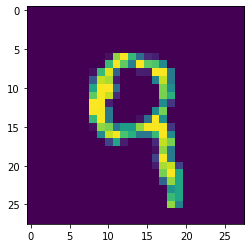

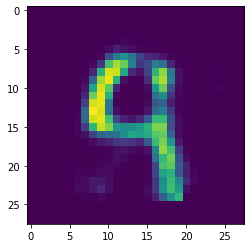

In [118]:
idx = 15 #change this to see different examples

plt.figure()
plt.imshow(data_example[idx][0].detach().numpy())

plt.figure()
plt.imshow(output_ae[idx][0].detach().numpy())

So, great - we have a neural network that can predict the input from the input. Is this useful? Recall that we had an intermediate layer that had 50 activations. Feel free to change this number around and see what happens.

We are compressing 784 pixel values into 50 activations and then reconstructing the image from those 50 values. In other words, we are forcing the neural network to capture only relevant non-linear features that can help it remember what image the input was.

The compression is not perfect as you can see in the reconstructed image above but it's pretty good. Training for more time or better training methods might improve this.

So how exactly is this useful. Maybe:

* Using an autoencoder to do lossy compression. Image storing the 50 activations instead of each image and storing the last layer (the "decoder") that constructs the image from the 50 activations.

* For search: suppose we wanted to search for a target image in a database of N images. We could do N pixel-by-pixel matches but these won't work because even a slight change in position or orientation or pixel intensities will give misleading distances between images. But if we use the vector of intermediate (50, in this case) activations, then maybe we can do a search in the space of activations. Let's try that.

In [119]:
#full mnist data
print(mnist_train.data.float().shape)

torch.Size([60000, 28, 28])


Generally it's a good idea to split the forward function into an encoder and decoder function. Here we do it explicitly.

In [120]:
image_ff_ae.net

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=784, bias=True)
  (4): Sigmoid()
)

Compute the activations after the hidden relu

In [121]:
with torch.no_grad():
    mnist_ae_act = image_ff_ae.net[2](image_ff_ae.net[1](image_ff_ae.net[0](mnist_train.data.float())))

In [122]:
mnist_ae_act.shape

torch.Size([60000, 50])

Let's pick some example image

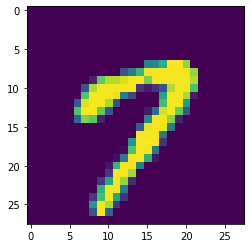

In [123]:
img_idx = 15 #between 0 and 60000-1

plt.imshow(mnist_train.data[img_idx])

Get the target image activation

In [124]:
target_img_act = mnist_ae_act[img_idx]

In [125]:
target_img_act

tensor([1957.2499,    0.0000,    0.0000, 1670.5452,  478.5717,    0.0000,
           0.0000,    0.0000,  734.0564, 1555.1993,    0.0000,    0.0000,
        1465.1163,    0.0000,    0.0000, 2259.1897,    0.0000,    0.0000,
         728.6481,    0.0000,  280.8365,  517.3596,    0.0000,  679.8279,
           0.0000,    0.0000, 2435.6868,    0.0000, 2472.4668,   70.3894,
        1497.7440,    0.0000,    0.0000,  865.6837,  918.8848,    0.0000,
        1033.2341,    0.0000,    0.0000,    0.0000, 2477.2898,    0.0000,
           0.0000, 2738.9695,    0.0000,    0.0000,    0.0000,    0.0000,
         239.9561,    0.0000])

We will use the cosine distance between two vectors to find the nearest neighbors. 

**Question**: Can you think of an elegant matrix-operation way of implementing this (so it can also run on a GPU)?

**Warning**: Always keep an eye out for memory usage. The full matrix of pairwise distances can be very large. Work with a subset of the data (even 100 images) if that's the case.

In [126]:
#to save memory, look at only first N images (1000 here)
mnist_ae_act = mnist_ae_act[0:1000, :]

The cosine distance between two points, $\vec{x}_i, \vec{x}_j$ is:

$$d_{ij} = \frac{\vec{x}_i . \vec{x}_j}{\lVert \vec{x}_i \rVert \lVert \vec{x}_j \rVert}$$

Now we can first normalize all the actiation vector so they have length 1.

In [127]:
torch.pow(mnist_ae_act, 2).sum(dim=1).shape

torch.Size([1000])

We can't divide a tensor of shape [60000, 50] (activations) by a tensor of shape [60000].

So first we have to unsqueeze (add an additional dimension) to get a shape [60000,1] and then broadcast/expand as the target tensor.

We should check that the first row contains the length of the first image's activations.

In [128]:
torch.pow(mnist_ae_act, 2).sum(dim=1).unsqueeze(1).expand_as(mnist_ae_act)

tensor([[46099880., 46099880., 46099880.,  ..., 46099880., 46099880.,
         46099880.],
        [53820988., 53820988., 53820988.,  ..., 53820988., 53820988.,
         53820988.],
        [13460633., 13460633., 13460633.,  ..., 13460633., 13460633.,
         13460633.],
        ...,
        [47730164., 47730164., 47730164.,  ..., 47730164., 47730164.,
         47730164.],
        [36204336., 36204336., 36204336.,  ..., 36204336., 36204336.,
         36204336.],
        [60187008., 60187008., 60187008.,  ..., 60187008., 60187008.,
         60187008.]])

Now we can divide by the norm (don't forget the sqrt).

In [129]:
mnist_ae_act_norm = mnist_ae_act / torch.pow(torch.pow(mnist_ae_act, 2).sum(dim=1).unsqueeze(1).expand_as(mnist_ae_act), 0.5)

Let's check an example.

In [130]:
mnist_ae_act[10]

tensor([1640.7133,    0.0000,    0.0000, 1539.2975,    0.0000,    0.0000,
           0.0000,    0.0000,   24.2063, 1558.2723,    0.0000,    0.0000,
         681.0084,    0.0000,    0.0000, 2798.3018,    0.0000,    0.0000,
        1747.0908,    0.0000, 2217.5720,    0.0000,    0.0000, 2367.3489,
           0.0000,    0.0000,  382.8511,    0.0000, 1896.9814,  993.6824,
        1697.6602,    0.0000,  909.1853, 1215.5568, 3196.3577,    0.0000,
         957.1897,    0.0000,    0.0000,    0.0000, 1107.1426,    0.0000,
         200.9913, 1943.6577,    0.0000,    0.0000,    0.0000,    0.0000,
        2571.5581,    0.0000])

In [131]:
torch.pow(torch.pow(mnist_ae_act[10], 2).sum(), 0.5)

tensor(7878.2793)

In [132]:
mnist_ae_act[10] / torch.pow(torch.pow(mnist_ae_act[10], 2).sum(), 0.5)

tensor([0.2083, 0.0000, 0.0000, 0.1954, 0.0000, 0.0000, 0.0000, 0.0000, 0.0031,
        0.1978, 0.0000, 0.0000, 0.0864, 0.0000, 0.0000, 0.3552, 0.0000, 0.0000,
        0.2218, 0.0000, 0.2815, 0.0000, 0.0000, 0.3005, 0.0000, 0.0000, 0.0486,
        0.0000, 0.2408, 0.1261, 0.2155, 0.0000, 0.1154, 0.1543, 0.4057, 0.0000,
        0.1215, 0.0000, 0.0000, 0.0000, 0.1405, 0.0000, 0.0255, 0.2467, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3264, 0.0000])

In [133]:
mnist_ae_act_norm[10]

tensor([0.2083, 0.0000, 0.0000, 0.1954, 0.0000, 0.0000, 0.0000, 0.0000, 0.0031,
        0.1978, 0.0000, 0.0000, 0.0864, 0.0000, 0.0000, 0.3552, 0.0000, 0.0000,
        0.2218, 0.0000, 0.2815, 0.0000, 0.0000, 0.3005, 0.0000, 0.0000, 0.0486,
        0.0000, 0.2408, 0.1261, 0.2155, 0.0000, 0.1154, 0.1543, 0.4057, 0.0000,
        0.1215, 0.0000, 0.0000, 0.0000, 0.1405, 0.0000, 0.0255, 0.2467, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3264, 0.0000])

Good! They are the same. We have confidence that we are normalizing the activation vectors correctly.

So now the cosine distance is:

$$d_{ij} = \vec{x}_i . \vec{x}_j$$

since all the vectors are of unit length.

**Question**: How would you compute this using matrix operations?

In [134]:
mnist_ae_act_norm.transpose(1, 0).shape

torch.Size([50, 1000])

In [135]:
mnist_ae_act_norm.shape

torch.Size([1000, 50])

In [136]:
ae_pairwise_cosine = torch.mm(mnist_ae_act_norm, mnist_ae_act_norm.transpose(1,0))

In [137]:
ae_pairwise_cosine.shape

torch.Size([1000, 1000])

In [138]:
ae_pairwise_cosine[0].shape

torch.Size([1000])

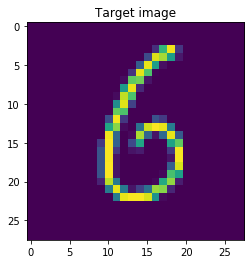

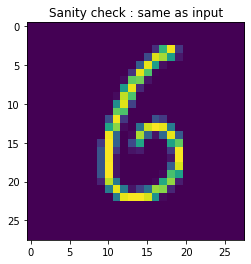

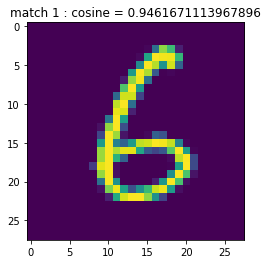

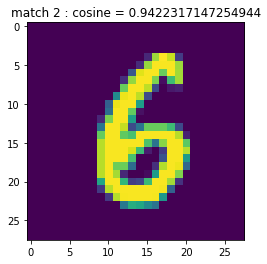

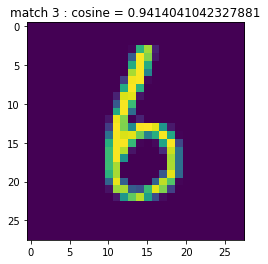

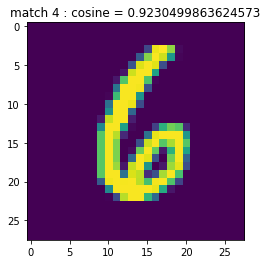

In [139]:
img_idx = 18 #between 0 and 60000-1

plt.imshow(mnist_train.data[img_idx])
plt.title("Target image")

#find closest image
top5 = torch.sort(ae_pairwise_cosine[img_idx], descending=True) #or use argsort
top5_vals = top5.values[0:5]
top5_idx = top5.indices[0:5]

for i, idx in enumerate(top5_idx):
    plt.figure()
    plt.imshow(mnist_train.data[idx])
    if i==0:
        plt.title("Sanity check : same as input")
    else:
        plt.title(f"match {i} : cosine = {top5_vals[i]}")

While this is a simple dataset and a simple autoencoder, we already have some pretty good anecdotal similarity searches. There are many variations on autoencoders from switching layers to adding noise to the inputs (denoising autoencoders) to adding sparsity penalties to the hidden layer activations to encourage sparse activations to graphical models called variational autoencoders.

Delete activations and cosine distances to save memory

In [140]:
del mnist_ae_act
del mnist_ae_act_norm
del ae_pairwise_cosine

### Recurrent Neural Networks

**Note**: You might have run into memory issues by now. Everything below is self contained so if you want to reset the notebook and start from the cell below, it should work.

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier, MLPRegressor

import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


As before, let's generate some toy data.

In [142]:
def generate_rnn_data(N_examples=1000, noise_var = 0.1, lag=1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ts = 4 + 3*np.arange(N_examples) + np.random.normal(0, noise_var)        
        
    features = ts[0:len(ts)-lag]
    target = ts[lag:]
    
    return features, target    

In [143]:
features, target = generate_rnn_data()

This data is possibly the simplest time-series one could pick (apart from a constant value). It's a simple linear trend with a tiny bit of gaussian noise.

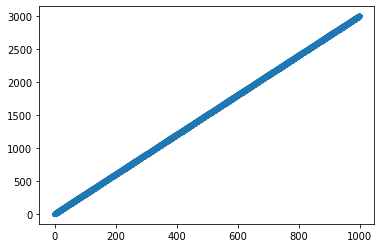

In [144]:
plt.plot(features, 'p')

We want to predict the series at time t+1 given the value at time t (and history).

Of course, we could try using a feed-forward network for this. But instead, we'll use this to introduce recurrent neural networks.

Recall that the simplest possible recurrent neural network has a hidden layer that evolves in time, $h_t$, inputs $x_t$ and outputs $y_t$.

$$h_t = \sigma(W_{hh} h_{t-1} + W_{hx} x_t + b_h)$$

with outputs:

$$y_t = W_{yh} h_t + b_y$$

Since the output is an unbounded real value, we won't have an activation on the output.

Let's write our simple RNN. This is not general - we don't have the flexibility of adding more layers (as discussed in the lecture), bidirectionality etc. but we are in experimental mode so it's okay. Eventually, you can use pytorch's in-built torch.nn.RNN class definition.

In [145]:
N_input = 1 #will pass only one value as input
N_output = 1 #will predict one value

N_hidden = 32 #number of hidden dimensions to use

hidden_activation = nn.ReLU()

#define weights and biases
w_hh = nn.Parameter(data = torch.Tensor(N_hidden, N_hidden), requires_grad = True)
w_hx = nn.Parameter(data = torch.Tensor(N_hidden, N_input), requires_grad = True)
w_yh = nn.Parameter(data = torch.Tensor(N_output, N_hidden), requires_grad = True)

b_h = nn.Parameter(data = torch.Tensor(N_hidden, 1), requires_grad = True)
b_y = nn.Parameter(data = torch.Tensor(N_output, 1), requires_grad = True)

#initialize weights and biases (in-place)
nn.init.kaiming_uniform_(w_hh)
nn.init.kaiming_uniform_(w_hx)
nn.init.kaiming_uniform_(w_yh)

nn.init.zeros_(b_h)
nn.init.zeros_(b_y)

Parameter containing:
tensor([[0.]], requires_grad=True)

In [146]:
hidden_act = hidden_activation(torch.mm(w_hx, torch.ones(N_input, 1)) + \
                               torch.mm(w_hh, torch.ones(N_hidden, 1)) + \
                               b_h)
print(hidden_act.shape)

torch.Size([32, 1])


In [147]:
output = (torch.mm(w_yh, hidden_act) + b_y)
print(output.shape)

torch.Size([1, 1])


But the input we'll be passing will be a time-series

In [148]:
inp_ts = torch.Tensor([1,2,3]).unsqueeze(1).unsqueeze(2)
print(inp_ts.shape)

torch.Size([3, 1, 1])


In [149]:
inp_ts[0]

tensor([[1.]])

In [150]:
inp_ts[0].shape

torch.Size([1, 1])

In [151]:
hidden_act = torch.zeros(N_hidden, 1)

#-----------first iter--------
hidden_act = hidden_activation(torch.mm(w_hx, inp_ts[0]) + \
                               torch.mm(w_hh, hidden_act) + \
                               b_h)
print(hidden_act.shape)

output = (torch.mm(w_yh, hidden_act) + b_y)
print(output)

#-----------second iter--------
hidden_act = hidden_activation(torch.mm(w_hx, inp_ts[1]) + \
                               torch.mm(w_hh, hidden_act) + \
                               b_h)
print(hidden_act.shape)

output = (torch.mm(w_yh, hidden_act) + b_y)
print(output)

#-----------third iter--------
hidden_act = hidden_activation(torch.mm(w_hx, inp_ts[2]) + \
                               torch.mm(w_hh, hidden_act) + \
                               b_h)
print(hidden_act.shape)

output = (torch.mm(w_yh, hidden_act) + b_y)
print(output)

torch.Size([32, 1])
tensor([[0.1966]], grad_fn=<AddBackward0>)
torch.Size([32, 1])
tensor([[-0.3508]], grad_fn=<AddBackward0>)
torch.Size([32, 1])
tensor([[-1.1414]], grad_fn=<AddBackward0>)


In [152]:
hidden_act = torch.zeros(N_hidden, 1)

for x in inp_ts: #input time-series 
    hidden_act = hidden_activation(torch.mm(w_hx, x) + \
                                   torch.mm(w_hh, hidden_act) + \
                                   b_h)
    print(hidden_act.shape)

    output = (torch.mm(w_yh, hidden_act) + b_y)
    print(output)

torch.Size([32, 1])
tensor([[0.1966]], grad_fn=<AddBackward0>)
torch.Size([32, 1])
tensor([[-0.3508]], grad_fn=<AddBackward0>)
torch.Size([32, 1])
tensor([[-1.1414]], grad_fn=<AddBackward0>)


In [153]:
class RNN(nn.Module):
    def __init__(self, N_input, N_hidden, N_output, hidden_activation):
        super(RNN, self).__init__()
        
        self.N_input = N_input
        self.N_hidden = N_hidden
        self.N_output = N_output
        self.hidden_activation = hidden_activation
        
        #define weights and biases
        self.w_hh = nn.Parameter(data = torch.Tensor(N_hidden, N_hidden), requires_grad = True)
        self.w_hx = nn.Parameter(data = torch.Tensor(N_hidden, N_input), requires_grad = True)
        self.w_yh = nn.Parameter(data = torch.Tensor(N_output, N_hidden), requires_grad = True)

        self.b_h = nn.Parameter(data = torch.Tensor(N_hidden, 1), requires_grad = True)
        self.b_y = nn.Parameter(data = torch.Tensor(N_output, 1), requires_grad = True)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.kaiming_uniform_(self.w_hh)
        nn.init.kaiming_uniform_(self.w_hx)
        nn.init.kaiming_uniform_(self.w_yh)

        nn.init.zeros_(self.b_h)
        nn.init.zeros_(self.b_y)                        
            
    def forward(self, inp_ts, hidden_act=None):
        if hidden_act is None:
            #initialize to zero if hidden not passed
            hidden_act = torch.zeros(self.N_hidden, 1)
            

        output_vals = torch.tensor([])
        for x in inp_ts: #input time-series 
            hidden_act = self.hidden_activation(torch.mm(self.w_hx, x) + \
                                                torch.mm(self.w_hh, hidden_act) + \
                                                self.b_h)

            output = (torch.mm(self.w_yh, hidden_act) + self.b_y)
            output_vals = torch.cat((output_vals, output))
            
        return output_vals, hidden_act

In [154]:
rnn = RNN(N_input, N_hidden, N_output, hidden_activation)

In [155]:
output_vals, hidden_act = rnn(inp_ts)

In [156]:
print(output_vals)
print("---------")
print(hidden_act)

tensor([[ 0.1640],
        [ 0.1395],
        [-0.8360]], grad_fn=<CatBackward>)
---------
tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 6.9510],
        [ 1.4375],
        [ 0.0000],
        [ 0.0000],
        [ 1.6526],
        [ 0.5433],
        [ 6.4337],
        [ 0.0409],
        [ 7.4663],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.9818],
        [ 0.6194],
        [ 6.4423],
        [ 0.0000],
        [10.3542],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 3.2046],
        [ 1.0121]], grad_fn=<ReluBackward0>)


So far so good. Now how do we actually tune the weights? As before, we want to compute a loss between the predictions from the RNN and the labels. Once we have a loss, we can do the usual backpropagation and gradient descent.

Recall that our "features" are:


$$x_1, x_2, x_3\ldots$$

Our "targets" are:

$$x_2, x_3, x_4 \ldots$$

if the lag argument in generate_rnn_data is 1. More generally, it would be:

$$x_{1+\text{lag}}, x_{2+\text{lag}}, x_{3+\text{lag}}, \ldots$$

Now, let's focus on the operational aspects for a second. In principle, you would first feed $x_1$ as an input, generate an **estimate** for $\hat{x}_2$ as the output.

Ideally, this would be close to the actual value $x_2$ but that doesn't have to be the case, especially when the weights haven't been tuned yet. Now, for the second step, we need to input $x_2$ to the RNN. The question is whether we should use $\hat{x}_2$ or $x_2$.

In real-life, one can imagine forecasting a time-series into the future given values till time t. In this case, we would have to feed our prediction at time t, $\hat{x}_{t+1}$ as input at the next time-step since we don't know $x_{t+1}$.

The problem with this approach is that errors start compounding really fast. While we might be a bit off at $t+1$, if our prediction $\hat{x}_{t+1}$ is inaccurate, then our prediction $\hat{x}_{t+2}$ will be even worse and so on.

In our case, we'll use what's called **teacher forcing**. We'll always feed the actual known $x_t$ at time-step t instead of the prediction from the previous time-step, $\hat{x}_t$.

**Question**: Split the features and target into train and test sets.

In [157]:
N_examples = len(features)

TRAIN_PERC = 0.70

TRAIN_SPLIT = int(TRAIN_PERC * N_examples)

features_train = features[:TRAIN_SPLIT]
target_train = target[:TRAIN_SPLIT]

features_test = features[TRAIN_SPLIT:]
target_test = target[:TRAIN_SPLIT]

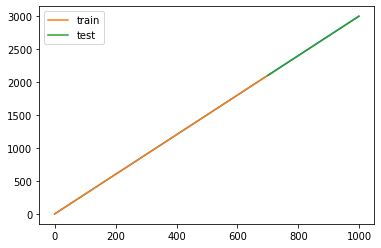

In [158]:
plt.plot(np.concatenate([features_train, features_test]))
plt.plot(features_train, label='train')
plt.plot(np.arange(len(features_train)+1, len(features)+1), features_test, label='test')
plt.legend()

In [159]:
criterion = nn.MSELoss()

optimizer = optim.Adam(rnn.parameters(), lr=1e-3)

In [160]:
N_input = 1 #will pass only one value as input
N_output = 1 #will predict one value
N_hidden = 32 #number of hidden dimensions to use

hidden_activation = nn.ReLU()

rnn = RNN(N_input, N_hidden, N_output, hidden_activation)

In [161]:
features_train = torch.tensor(features_train).unsqueeze(1).unsqueeze(2)
target_train = torch.tensor(target_train).unsqueeze(1).unsqueeze(2)

features_test = torch.tensor(features_test).unsqueeze(1).unsqueeze(2)
target_test = torch.tensor(target_test).unsqueeze(1).unsqueeze(2)

In [162]:
output_vals, hidden_act = rnn(features_train.float())

In [163]:
print(len(output_vals))
print(len(target_train))

699
699


In [164]:
loss = criterion(torch.tensor(output_vals).double(), target_train.squeeze(2).squeeze(1))

/home/sanjay/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/sanjay/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([699])) that is different to the input size (torch.Size([699, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [165]:
loss.requires_grad = True

In [166]:
print(loss)

tensor(7261342.8136, dtype=torch.float64, requires_grad=True)


In [167]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

We can now put all these ingredients together

In [168]:
N_input = 1 #will pass only one value as input
N_output = 1 #will predict one value
N_hidden = 4 #number of hidden dimensions to use

hidden_activation = nn.Tanh()

rnn = RNN(N_input, N_hidden, N_output, hidden_activation)

criterion = nn.MSELoss()

optimizer = optim.Adam(rnn.parameters(), lr=1e-1)

N_epochs = 10

hidden_act = None

for n in range(N_epochs):
    output_vals, hidden_act = rnn(features_train.float(), hidden_act = None)
    
    loss = criterion(output_vals, target_train.squeeze(1).float())
    
    #loss.requires_grad = True
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if n % 100 == 0:
        print(rnn.w_yh.grad)
        print(f'loss = {loss}')
        print(output_vals.requires_grad)

tensor([[-2110.3474, -2110.3474, -2110.3474, -2110.3474]])
loss = 1479841.75
True


In [169]:
output_vals.shape

torch.Size([699, 1])

In [170]:
criterion(output_vals, target_train.squeeze(1).float())

tensor(1470366.6250, grad_fn=<MseLossBackward>)

In [171]:
features_train[0:10]

tensor([[[ 3.9764]],

        [[ 6.9764]],

        [[ 9.9764]],

        [[12.9764]],

        [[15.9764]],

        [[18.9764]],

        [[21.9764]],

        [[24.9764]],

        [[27.9764]],

        [[30.9764]]], dtype=torch.float64)

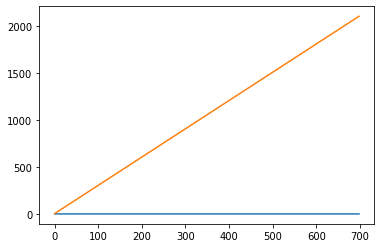

In [172]:
plt.plot([i.item() for i in output_vals])
plt.plot([i[0] for i in target_train.numpy()])

In [173]:
rnn.w_hh.grad

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0028, 0.0028, 0.0028, 0.0026]])

In [174]:
#optimizer.zero_grad()
#loss.requires_grad = True
#loss.backward()
#optimizer.step()

In [175]:
rnn.w_hh

Parameter containing:
tensor([[-0.3174,  0.9362, -0.3568,  1.1171],
        [-0.6842,  0.9830,  0.4597, -1.1498],
        [ 0.3126,  0.7084, -0.9353,  0.9816],
        [-1.5413, -1.1459, -0.1111, -1.0152]], requires_grad=True)

In [176]:
rnn.w_hx.grad

tensor([[-4.9063e-09],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.9485e-02]])